In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Classic Imports.

In [2]:
directory = '/kaggle/input/face-mask-detection/Dataset'

image_dataset = torchvision.datasets.ImageFolder(directory, transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))

We resize to 224 px and normalize with the mean and std_dev, to follow the standard practice of ResNet. We have a random horizontal flip to ensure that we don't overfit.

In [3]:
assert len(image_dataset) == 2994 * 3

Let's make sure we have all our images. Each folder has 2994 images each and we have three folders (one folder per class). Hence, all together our dataset should have 8982 images.

In [4]:
import math
testing_split = math.floor(0.1 * len(image_dataset))
print(testing_split)
validation_split = math.floor(0.1 * len(image_dataset))
print(validation_split)
training_split = len(image_dataset) - (testing_split + validation_split)
print(training_split)

898
898
7186


We use a standard 80-10-10 split for training, test, and validation. We must make our own as our Kaggle dataset didn't predefine any testing or training set.

In [5]:
train_set, test_set, val_set = torch.utils.data.random_split(image_dataset, [training_split, testing_split, validation_split])
trainloader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=8, shuffle=False, num_workers=2)

Let's load our data.

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


Our imshow method, taking into account the previous mean and std values for Resnet training.

In [7]:
class_names = train_set.dataset.classes
print(class_names)

['mask_weared_incorrect', 'with_mask', 'without_mask']


Let's see what labels we have. 

torch.Size([4, 3, 224, 224])


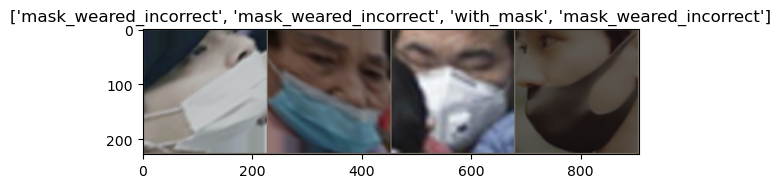

In [8]:
dataiter = iter(trainloader)
images, classes = next(dataiter)
images = images[:4]
print(images.size())
imshow(torchvision.utils.make_grid(images), title=[class_names[x] for x in classes[:4]])
plt.savefig('ExampleFig.png')

Just a quick check to see that we are training on valid data and that our labels are accurate.

In [9]:
import copy
def train(net, trainloader, valloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    
    best_accuracy = 0.0 # Keep track of the best performing model every epoch
    best_wts = copy.deepcopy(net.state_dict()) # Record best performing model parameters
    
    training_losses = []
    training_accuracy = []
    val_losses = []
    val_accuracy = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr/50, momentum=momentum, weight_decay=decay)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(trainloader), epochs=epochs, div_factor=50, final_div_factor=5000, verbose=verbose)
    
    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        for phase in ["train", "val"]: # Two phase process for Validation
            sum_loss = 0.0
            sum_correct = 0.0
            if phase == "train":   # Standard minibatch SGD like previous train methods
                dataloader = trainloader
                losses = training_losses
                accuracy = training_accuracy
           
                for i, batch in enumerate(dataloader, 0):
                    inputs, labels = batch[0].to(device), batch[1].to(device)

                    optimizer.zero_grad()

                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    loss.backward()  # autograd magic, computes all the partial derivatives
                    optimizer.step() # takes a step in gradient direction

                    losses.append(loss.item()) # Total loss per minibatch is recorded
                    accuracy.append(torch.sum(preds == labels.data) / 8) # Accuracy per minibatch
                    
                    sum_loss += loss.item()
                    sum_correct += torch.sum(preds == labels.data)

                    scheduler.step()

                    if i % print_every == print_every-1:    # print every 10 mini-batches
                        if verbose:
                             # Print average total training loss every over 10 minibatches
                            print(str(phase) + ' [%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                            # Print average accuracy percentage every 10 minibatches.
                            print(str(phase) + ' [%d, %5d] acc: %.3f' % (epoch, i + 1, sum_correct / (print_every * 8))) 
                            
                        sum_loss = 0.0
                        sum_correct = 0.0
            else: # Our new validation phase
                dataloader = valloader
                losses = val_losses
                accuracy = val_accuracy 
                for i, batch in enumerate(dataloader, 0):
                    inputs, labels = batch[0].to(device), batch[1].to(device)

                    optimizer.zero_grad()

                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    sum_loss += loss.item()
                    sum_correct += torch.sum(preds == labels.data)

                # Data is recorded and printed out per epoch. 
                # Total loss and accuracy per epoch is recorded computed over the entire validation dataset.
                epoch_accuracy = sum_correct / validation_split
                losses.append(sum_loss)
                accuracy.append(epoch_accuracy)
                print(str(phase) + ' %d loss: %.3f' % (epoch, sum_loss))
                print(str(phase) + ' %d acc: %.3f' % (epoch,  epoch_accuracy))
                
                # Check if performs better than previous epoch
                if epoch_accuracy > best_accuracy:
                    best_accuracy = epoch_accuracy
                    best_wts = copy.deepcopy(net.state_dict())
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'training losses': training_losses, 'training accuracy': training_accuracy, "validation losses" : val_losses, "validation accuracy" : val_accuracy}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    print(f'Best validation accuracy: {best_accuracy:4f}')
    net.load_state_dict(best_wts)
    return net, training_losses, training_accuracy, val_losses, val_accuracy

This training method is based on the original training method in the Bird Classification shown in class. However, it has been modified to take into account for a validation phase and to calculate average accuracy per phase. Notice the difference in the data we record and print (for training, loss and accuracy are recorded per batch, but for training print out, the losses and accuracy statistics are the average of 10 minibatches. For validation, training loss and accuracy data is recorded and printed out per epoch.

In [10]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(class_names))

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 39.3MB/s]


Let's import resnet for our transfer learning.

In [11]:
resnet, training_losses, training_accuracy, val_losses, val_accuracy = train(resnet, trainloader, valloader, epochs=10, lr=.05, print_every=10, checkpoint_path='./')

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0001e-03.
Adjusting learning rate of group 0 to 1.0001e-03.
Adjusting learning rate of group 0 to 1.0003e-03.
Adjusting learning rate of group 0 to 1.0004e-03.
Adjusting learning rate of group 0 to 1.0006e-03.
Adjusting learning rate of group 0 to 1.0008e-03.
Adjusting learning rate of group 0 to 1.0011e-03.
Adjusting learning rate of group 0 to 1.0013e-03.
Adjusting learning rate of group 0 to 1.0017e-03.
train [0,    10] loss: 0.899
train [0,    10] acc: 0.575
Adjusting learning rate of group 0 to 1.0020e-03.
Adjusting learning rate of group 0 to 1.0024e-03.
Adjusting learning rate of group 0 to 1.0028e-03.
Adjusting learning rate of group 0 to 1.0033e-03.
Adjusting learning rate of group 0 to 1.0037e-03.
Adjusting learning rate of group 0 to 1.0043e-03.
Adjusting learning rate of group 0 to 1.0048e-03.
Adjusting learning rate of group 0 to 1.005

Let's train!

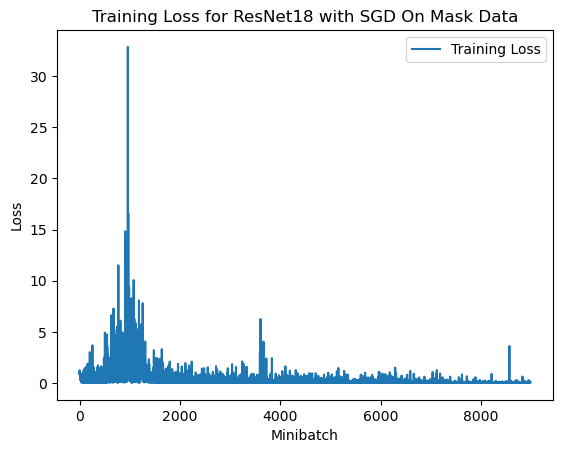

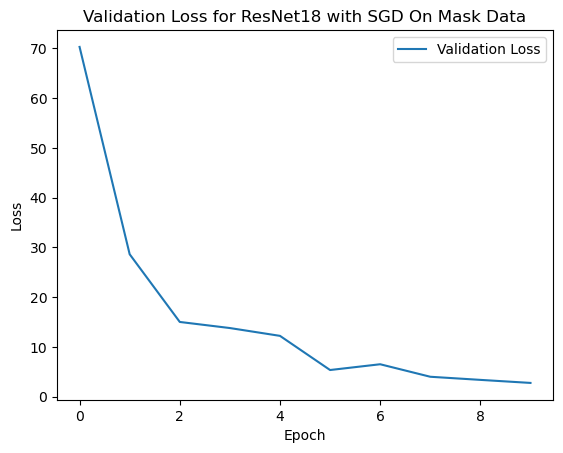

In [24]:
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Minibatch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss for ResNet18 with SGD On Mask Data')
plt.savefig('Mask ResNet18 SGD Training Loss.png')
plt.show()

plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Loss for ResNet18 with SGD On Mask Data')
plt.savefig('Mask ResNet18 SGD Validation Loss.png')
plt.show()

Let's visualize our losses. For training loss, each point represents the training loss of a single minibatch. For our validation loss, each point is the total validation loss across our entire validation dataset per epoch.

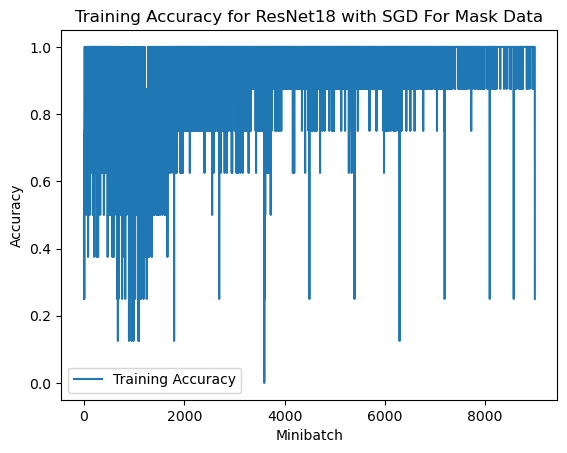

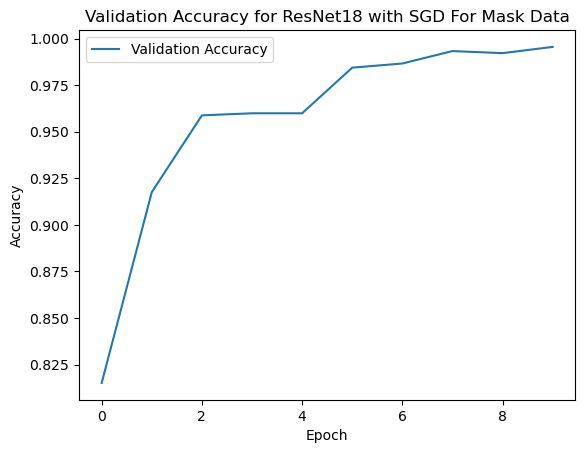

In [25]:
plt.plot([acc.cpu() for acc in training_accuracy], label='Training Accuracy')
plt.xlabel('Minibatch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy for ResNet18 with SGD For Mask Data')
plt.savefig('Mask ResNet18 SGD Training Accuracy.png')
plt.show()

plt.plot([acc.cpu() for acc in val_accuracy], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy for ResNet18 with SGD For Mask Data')
plt.savefig('Mask ResNet18 SGD Validation Accuracy.png')
plt.show()

Let's visualize our accuracy. For training accuracy, each point represents the training accuracy of a single minibatch. For our validation accuracy, each point is the validation accuracy across our entire validation dataset per epoch.

In [26]:
def test_accuracy(net):
    correct = 0.0
    
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1)
            
            correct += torch.sum(preds == labels.data)
    
    accuracy = correct / testing_split
    
    print(f'Test accuracy: {accuracy:4f}')
    
    return accuracy

In [27]:
test_accuracy(resnet)

Test accuracy: 0.978842


tensor(0.9788, device='cuda:0')

Our best trained net has a pretty good accuracy.

In [28]:
import random

def demonstration(net):
    dataiter = iter(testloader)
    random_int = random.randrange(len(testloader))
    print(random_int)
    accuracy = 0.0
    for x in range(random_int + 1):
        images, classes = next(dataiter)
    inputs = images.to(device)
    labels = classes.to(device)
    
    outputs = net(inputs)
    _, preds = torch.max(outputs, 1)
    
    accuracy += torch.sum(preds == labels.data).item()
    print(accuracy / 4)
    preds = preds.to('cpu').numpy()
    print(preds)
    imshow(torchvision.utils.make_grid(images), title=[class_names[x] for x in preds])
    plt.savefig('Mask demonstration.png')

154
1.0
[0 2 2 2]


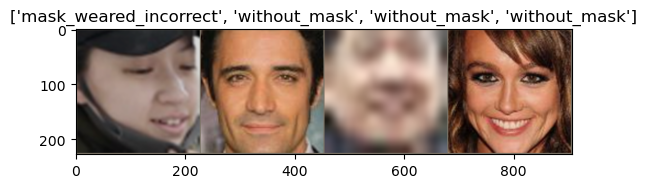

In [29]:
demonstration(resnet)

We see that our model can correctly label the actions of the driver from a random batch within our testing dataset.